## Analisis exploratorio de los datos de partida
El objetivo de este notebook es la realización de un analisis exploratorio de los datos a tratar, siendo este el primer paso de cualquier proyecto de analisis y modelado de datos.

### Análisis sobre los textos
En primero lugar, realizamos un pequeño estudio estadístico de los textos sobre los que trabajaremos. El siguiente bloque de código construye dos funciones, una para describir estadísticamente los textos con los que contamos, `escribe_collection`, y una función auxiliar que cuenta el número de palabras de un documento, `count_words`. Además, antes de las funciones importamos todas las librerías necesarias para toda la práctica.

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("whitegrid")  # estilo de fondo y cuadrícula
sns.set_palette("viridis")  # paleta de colores


# Función para contar palabras

def count_words(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        text = file.read()
    words = text.split()
    return len(words)

    

# Función para describir la colección

def describe_collection(root_path="../data/raw"):
    stats_by_group = {}

    for group_name in os.listdir(root_path):
        group_path = os.path.join(root_path, group_name)
        
        if os.path.isdir(group_path):
            file_lengths = []
            for filename in os.listdir(group_path):
                file_path = os.path.join(group_path, filename)
                word_count = count_words(file_path)
                file_lengths.append(word_count)
            
            num_documents = len(file_lengths)
            mean_words = np.mean(file_lengths)
            std_words = np.std(file_lengths)

            stats_by_group[group_name] = {
                'num_documents': num_documents,
                'mean_words': mean_words,
                'std_words': std_words
            }

    # Mostrar resultados
    for group, stats in stats_by_group.items():
        print(f"Grupo: {group}")
        print(f"Número de documentos: {stats['num_documents']}")
        print(f"Número medio de palabras: {stats['mean_words']:.2f}")
        print(f"Desviación estándar de palabras: {stats['std_words']:.2f}")
        print(f"Coeficiente de variación: {stats['std_words'] / stats['mean_words']:.2f}")
        print("-" * 50)
    
    return stats_by_group



In [9]:
stats = describe_collection("../data/raw")

Grupo: comp.sys.ibm.pc.hardware
Número de documentos: 124
Número medio de palabras: 247.70
Desviación estándar de palabras: 373.05
Coeficiente de variación: 1.51
--------------------------------------------------
Grupo: comp.sys.mac.hardware
Número de documentos: 146
Número medio de palabras: 184.38
Desviación estándar de palabras: 108.42
Coeficiente de variación: 0.59
--------------------------------------------------
Grupo: rec.autos
Número de documentos: 61
Número medio de palabras: 216.18
Desviación estándar de palabras: 170.52
Coeficiente de variación: 0.79
--------------------------------------------------
Grupo: rec.sport.hockey
Número de documentos: 50
Número medio de palabras: 273.88
Desviación estándar de palabras: 265.68
Coeficiente de variación: 0.97
--------------------------------------------------
Grupo: sci.electronics
Número de documentos: 211
Número medio de palabras: 265.78
Desviación estándar de palabras: 807.43
Coeficiente de variación: 3.04
-----------------------

#### Interpretación de los resultados
En primer lugar, observamos que los tamaños medios de los documentos varían mucho entre grupos. Por ejemplo, `talk.politics.mideast` y `talk.politics.guns` presentan medias significativamente más altas que las demás ($726.88$ y $414.33$ palabras respectivamente), mientras que grupos como `comp.sys.mac.hardware` y `rec.autos` tienen medias más bajas ($184.38$ y $216.18$).

Estudiando la dispersión de los datos vemos como algunas desviaciones estándar son muy altas respecto a su media (p. ej. `sci.electronics` con std=$807.43$ y `talk.politics.mideast` con std=$1321.51$). Esto sugiere la presencia de documentos muy largos o threads con contenido citado que inflan la longitud y lo que genera una distribución sesgada.

Para estudiar con más detalle la distribución del número de palabras de estos textos tomaremos el coeficiente de variación (std/mean). Observamos que varios grupos tienen dispersión relativa alta (>1), lo que indica que la longitud de documentos en esos grupos es muy heterogénea.

Esta distrubución de los datos debe tomarse en cosideración a la hora de realizar la tarea de cústering. Para representaciones textuales (TF/TF-IDF) hay que normalizar por longitud o usar técnicas que reduzcan el sesgo que introducen documentos muy largos.

Para conocer más sobre los datos de partida vamos a representar los diagramas de cajas y bigotes de los distintos grupos, lo que nos permite conocer la distribución de los perceltiles de forma visual.

In [18]:
# Función para graficar estadísticas

import matplotlib.pyplot as plt
import seaborn as sns

def prepare_boxplot_data(root_path):
    """
    Prepara un DataFrame para boxplot con columnas: 'Grupo', 'Palabras'
    """
    data = []
    for group_name in os.listdir(root_path):
        group_path = os.path.join(root_path, group_name)
        if os.path.isdir(group_path):
            for filename in os.listdir(group_path):
                file_path = os.path.join(group_path, filename)
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    text = f.read()
                num_words = len(text.split())
                data.append({'Grupo': group_name, 'Palabras': num_words})
    return pd.DataFrame(data)

def plot_boxplot(df, x):
    """
    Genera un boxplot horizontal mostrando la distribución de 'Palabras' por 'Grupo'.

    Args:
        df (pd.DataFrame): DataFrame con las columnas 'Grupo' y 'Palabras'.
    """
    sns.set_style("whitegrid")
    # Aumentamos el ancho (12) y reducimos la altura (7) para una mejor visualización horizontal
    plt.figure(figsize=(12, 7))

    # Boxplot horizontal: 'Grupo' en y, 'Palabras' en x
    ax = sns.boxplot(y='Grupo', x='Palabras', data=df, palette='viridis')

    # Limitar eje X (el de la variable 'Palabras') al percentil 99
    x_max = np.percentile(df['Palabras'], x)
    ax.set_xlim(0, x_max)

    ax.set_title(f"Distribución de palabras por grupo (percentil {x})", fontsize=14)
    ax.set_ylabel("Grupo", fontsize=12)
    ax.set_xlabel("Número de palabras", fontsize=12)
    # Ya no es necesario rotar las etiquetas del eje X, solo si los grupos fueran muy largos en Y
    plt.tight_layout()
    plt.savefig(f"../docs/images/boxplot_palabras_por_grupo_percentil_{x}.png")
    plt.show()

C:\Users\sabel\AppData\Local\Temp\ipykernel_7888\1113462827.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y='Grupo', x='Palabras', data=df, palette='viridis')


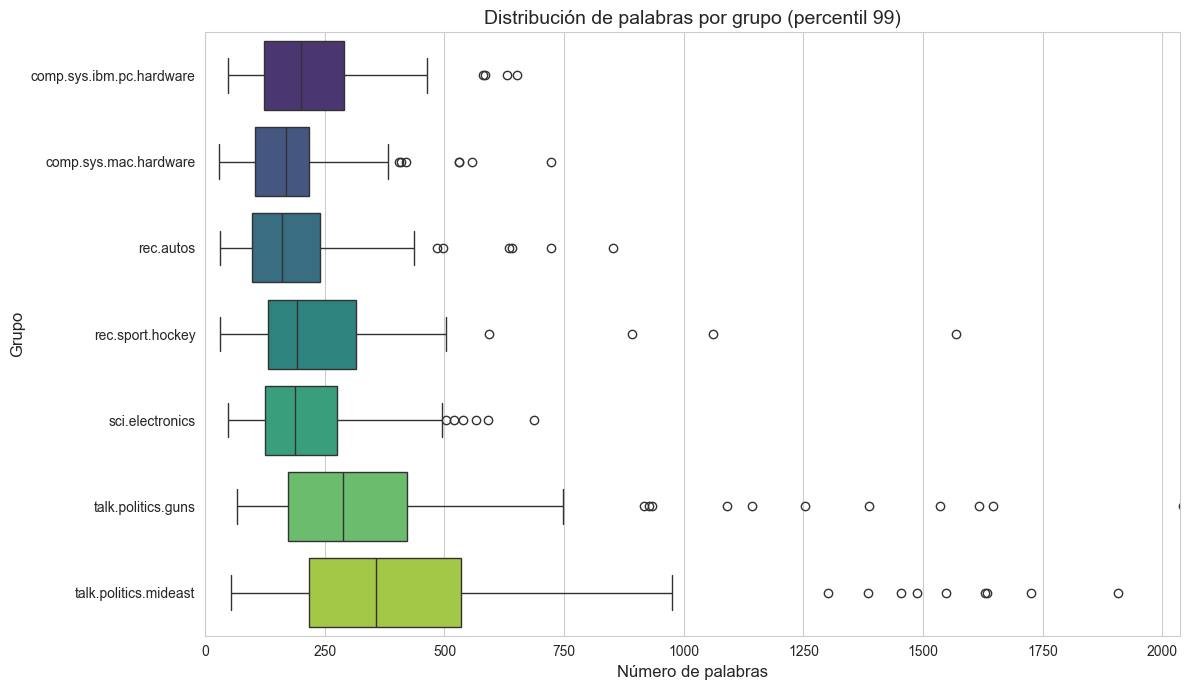

C:\Users\sabel\AppData\Local\Temp\ipykernel_7888\1113462827.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y='Grupo', x='Palabras', data=df, palette='viridis')


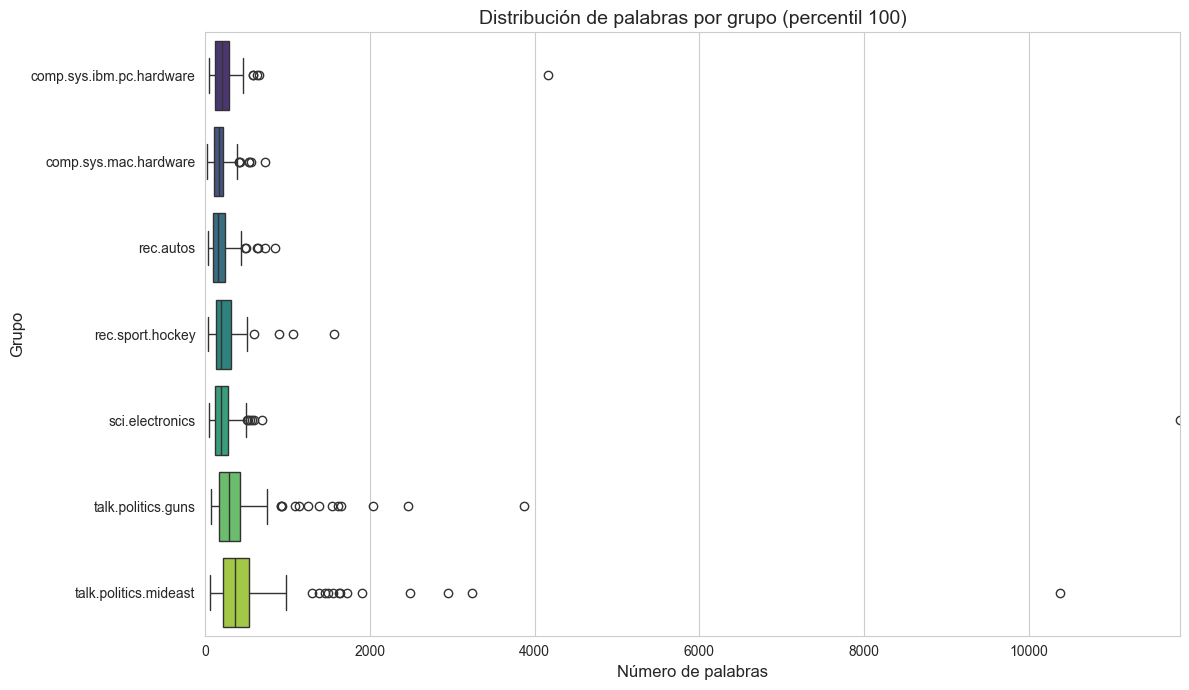

In [17]:
df = prepare_boxplot_data("../data/raw")
plot_boxplot(df,99)
plot_boxplot(df,100)

En la primera gráfica podemos notar la presencia de outliers excepcionalmente altos. Los grupos `talk.politics.guns` y `talk.politics.mideast` muestran una gran cantidad de valores atípicos de longitud extrema (más de $1000$ palabras), lo cual es coherente con su alta variabilidad. Esto puede perjudicar los resultados de nuestra tarea de clústering. Por ello, eliminaremos los registros fuera del percentil $99$.

 En la segunda imágen podemos ver la gráfica de cajas y bigotes recortarndo los ejes de forma que tengan el percentil $99$ de los datos, esto nos permite estudiar mejor la distribución de cada grupo. Podemos observar mayor variabilidad (caja y bigotes más largos) en los grupos `talk.politics.guns` y `talk.politics.mideast`, relacionadas con debates políticos, así como medias más alta. Esto suguiere que cuando se trata de hablar de estos, los usuarios tienden a poner mensajes más largos y los hilos de citados también crecen. Mientras tanto, los grupos relacionados con temáticas técnicas `comp.sys`, `sci.electronics` suelen  ser más cortos y concisos así como tener longitudes más estándar (no existe tanta variacíon).